Sentiment analysis of movie (IMDB) reviews using dataset provided by the ACL 2011 paper, 
see http://ai.stanford.edu/~amaas/data/sentiment/
This notebook uses neural net models

The plan is to compare a variety of hyperparameters, vectorization techniques, neural net based models:
* dense neural network with bag of words
* dense neural network with fixed size input and words mapped to integers
* LSTM
* CNN


### Table of Contents<a class="anchor" id="table"></a>
* [Load data](#load)
* [Train different architectures](#train)
    * [Train NN 50 - 10 - 1](#train1)
    * [Train NN 256 - 128 - 1](#train2)
    * [Train NN with K-Fold cross validation](#kfold)
    * [Train RNN](#rnn)
* [Optimize](#opti)
    * [Optimize on dropouts](#opti_d)
        * no dropout
        * low dropout on 1 layer
        * high dropout on 1 layer
        * low dropout on 2 layers
        * high dropout on 2 layers
        * [Observation](#opti_d_o)

In [2]:
!pip install wget

In [3]:
import numpy as np
import os
import os.path
import glob
import time

import pandas as pd
import matplotlib as plt

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
nltk.download('punkt')
import nltk
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /home/jeremie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from sklearn.model_selection import KFold

In [5]:
import wget
import tarfile

# By checking if the directory exists first, we allow people to delete the tarfile without the notebook re-downloading it
if os.path.isdir('aclImdb'):
    print("Dataset directory exists, taking no action")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading dataset")
        #!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
        wget.download('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    else:
        print("Dataset already downloaded")
    
    print("Unpacking dataset")
    #!tar -xf aclImdb_v1.tar.gz 
    tar = tarfile.open("aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()
    print("Dataset unpacked in aclImdb")

Dataset directory exists, taking no action


In [6]:
# configuration
SAMPLE_SIZE=1000

<a href='#table'>Back</a>
# Load data<a class="anchor" id="load"></a>

## Create a dense vector from reviews 

In [7]:
time_beginning_of_notebook = time.time()
positive_file_list = glob.glob(os.path.join('aclImdb/train/pos', "*.txt"))
positive_sample_file_list = positive_file_list[:SAMPLE_SIZE]

negative_file_list = glob.glob(os.path.join('aclImdb/train/neg', "*.txt"))
negative_sample_file_list = negative_file_list[:SAMPLE_SIZE]

import re

# load doc into memory
# regex to clean markup elements 
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf8')
    # read all text
    text = re.sub('<[^>]*>', ' ', file.read())
    #text = file.read()
    # close the file
    file.close()
    return text

In [8]:
positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_tokenized = [word_tokenize(s) for s in positive_strings]
negative_tokenized = [word_tokenize(s) for s in negative_strings]

In [9]:
from collections import Counter
import numpy as np

In [10]:
total_counts = Counter()
all_reviews = positive_tokenized + negative_tokenized
for r in all_reviews:
    for word in r:
        total_counts[word] += 1

In [11]:
vocab = set(total_counts.keys())

In [12]:
vocab_size = len(vocab)
print(vocab_size)

32832


In [13]:
# Create a dictionary of words in the vocabulary mapped to index positions
# (to be used in layer_0)
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i

In [14]:
print("ID of 'movie' = {}".format(word2index['movie']))

ID of 'movie' = 18418


In [15]:
def convert_to_bag(review):
    bag = np.zeros(vocab_size)
    for word in review:
        i = word2index[word]
        bag[i]+=1
    return bag

In [16]:
test_bag = convert_to_bag(all_reviews[0])


In [17]:
all_reviews_encoded = [convert_to_bag(x) for x in all_reviews]

In [18]:
all_reviews_encoded[0].shape

(32832,)

In [19]:
#all_reviews_trunc = np.trunc()

In [20]:
# display the map of words to indices
# print("word indexes = {}".format(word2index))

In [21]:
import random

positive_labels = []
for i in range(len(positive_tokenized)):
    positive_labels.append('POSITIVE')
negative_labels = []
for i in range(len(negative_tokenized)):
    negative_labels.append('NEGATIVE')
   

In [22]:
labels = positive_labels + negative_labels

num_lables = []

for val in labels:
    if val == 'POSITIVE':
       num_lables.append(1)
    else:
       num_lables.append(0) 
    

In [23]:
reviews_and_labels = list(zip(all_reviews_encoded, num_lables))
random.shuffle(reviews_and_labels)
reviews, labels = zip(*reviews_and_labels)

In [24]:
labels = np.array(labels)

## Create a sparse matrix from reviews (where we keep the order of the words)

In [39]:
positive_strings[0]

'I thought I should qualify my position after reading other reviews. The movie is not great, but it has a lot of great elements. The lighting and scenes along with the camera work are great. The story is slow and weak, but entertaining. The acting is bad, but no worse than you will find on the SyFy Channel. The music is pretty good and the gore is good. It has the great Leather Face in the film and is produced by Bruce Campbell. I watched the complete movie and while mostly predictable, it was still enjoyable. The women are attractive enough and the lead actor does a good job of being brooding and creepy. The movie was remarkably clean for a modern film and the violence appropriate for children 13 and up. There was no sex scenes. I gave it 7 out of 10 and I think that is fair. I would watch it again if I had nothing better to do. The gay sounding angel was the most annoying aspect of the film, the devil is quite creepy.'

In [43]:
reviews=[]
for sentence in positive_strings:
    reviews.append([sentence,1])
for sentence in negative_strings:
    reviews.append([sentence,0])
random.shuffle(reviews)


In [45]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',\
                                   lower=True, split=' ', char_level=False, oov_token=None, document_count=0)


In [46]:
len(reviews)

2000

<a href='#table'>Back</a>
# Train models<a class="anchor" id="train"></a>
## Train NN 50 - 10 - 1 <a class="anchor" id="train1"></a>


In [25]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [26]:
model = keras.Sequential()
model.add(layers.Dense(50, activation = "relu", input_shape=(vocab_size, )))
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1641650   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,642,171
Trainable params: 1,642,171
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

In [28]:
results = model.fit(
 X_train, y_train,
 epochs= 20,
 validation_data=(X_test, y_test),
batch_size=500
)

Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 1s 725us/step - loss: 0.6833 - acc: 0.5220 - val_loss: 0.6627 - val_acc: 0.6520
Epoch 2/20
1500/1500 [==============================] - 1s 469us/step - loss: 0.6049 - acc: 0.8013 - val_loss: 0.6378 - val_acc: 0.6160
Epoch 3/20
1500/1500 [==============================] - 1s 470us/step - loss: 0.5328 - acc: 0.7660 - val_loss: 0.5959 - val_acc: 0.7200
Epoch 4/20
1500/1500 [==============================] - 1s 470us/step - loss: 0.4631 - acc: 0.9427 - val_loss: 0.5828 - val_acc: 0.6880
Epoch 5/20
1500/1500 [==============================] - 1s 469us/step - loss: 0.4014 - acc: 0.9347 - val_loss: 0.5602 - val_acc: 0.7100
Epoch 6/20
1500/1500 [==============================] - 1s 472us/step - loss: 0.3535 - acc: 0.9760 - val_loss: 0.5581 - val_acc: 0.7120
Epoch 7/20
1500/1500 [==============================] - 1s 472us/step - loss: 0.3123 - acc: 0.9853 - val_loss: 0.5405 - val_acc: 0.7280
E

## Train NN 256 - 128 - 1 <a class="anchor" id="train2"></a>

In [111]:
model = keras.Sequential([
    layers.Dense(256, activation = "relu", input_shape=(vocab_size, )),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])

In [112]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 256)               8405248   
_________________________________________________________________
dense_64 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 129       
Total params: 8,438,273
Trainable params: 8,438,273
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

In [114]:
results = model.fit(
 X_train, y_train,
 epochs= 1,
 validation_data=(X_test, y_test),
batch_size=500
)

Train on 1500 samples, validate on 500 samples
Epoch 1/1
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6738 - acc: 0.6047 - val_loss: 0.6048 - val_acc: 0.6880


In [115]:
results.history

{'val_loss': [0.6047532558441162],
 'val_acc': [0.6880000233650208],
 'loss': [0.6737996737162272],
 'acc': [0.6046666701634725]}

## Train NN with K-Fold cross validation <a class="anchor" id="kfold"></a>

In [116]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [117]:
kfold = KFold(3, True, 1)

In [118]:
train_data = list(zip(X_train, y_train))

In [119]:
train_data[0][0].shape

(32832,)

In [120]:
histories=[]
for train_indices, test_indices in kfold.split(X_train,y=y_train):
    model = keras.Sequential([
    layers.Dense(256, activation = "relu", input_shape=(vocab_size, )),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(
     optimizer = "adam",
     loss = "binary_crossentropy",
     metrics = ["accuracy"]
    )
    K_X_train = X_train[train_indices]
    K_y_train = y_train[train_indices]
    K_X_test = X_train[test_indices]
    K_y_test = y_train[test_indices]
    results=model.fit(
        K_X_train, K_y_train,
        epochs= 5,
        validation_data=(K_X_test, K_y_test),
        batch_size=1000
    )
    histories.append(results.history)

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7022 - acc: 0.5020 - val_loss: 0.7173 - val_acc: 0.5280
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6728 - acc: 0.5110 - val_loss: 0.6345 - val_acc: 0.7300
Epoch 3/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.5178 - acc: 0.9530 - val_loss: 0.6641 - val_acc: 0.5600
Epoch 4/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4684 - acc: 0.8440 - val_loss: 0.5823 - val_acc: 0.7200
Epoch 5/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3615 - acc: 0.9640 - val_loss: 0.5143 - val_acc: 0.8100
Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6936 - acc: 0.5200 - val_loss: 0.6766 - val_acc: 0.5860
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.5940 - acc: 0.7360 - val_loss: 

mean acc: 0.9803333282470703, mean val_acc: 0.8073333303133646


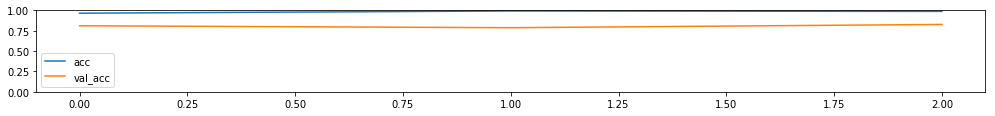

In [121]:

df = pd.DataFrame(data=histories)
for col in df.columns:
    df[col] =  df[col].apply(lambda x: x[-1])
plot=df[["acc","val_acc"]].plot()
plot.set_ylim([0,1])

means=df[["acc","val_acc"]].mean()
print("mean acc: {}, mean val_acc: {}".format(means["acc"],means["val_acc"]))


## Train RNN <a class="anchor" id="rnn"></a>

In [29]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<a href='#table'>Back</a>
# OPTIMIZE<a class="anchor" id="opti"></a>

## Optimize on dropout<a class="anchor" id="opti_d"></a>

In [122]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [123]:
kfold = KFold(3, True, 1)

In [124]:
train_data = list(zip(X_train, y_train))

In [125]:
# train_data[0][0].shape

In [126]:
from pdb import set_trace

def getMeansFromResultsHistory(histories):
  df = pd.DataFrame(data=histories)
  for col in df.columns:
      df[col] =  df[col].apply(lambda x: x[-1])
  means=df[["acc","val_acc"]].mean()
  return means

def trainModelWithDropoutOn1Layer(epochs_nb=5,rate=0.0):
  histories=[]
  for train_indices, test_indices in kfold.split(X_train,y=y_train):
      model = keras.Sequential([
      layers.Dense(256, activation = "relu", input_shape=(vocab_size, )),
      layers.Dropout(rate),
      layers.Dense(128, activation = "relu"),
      layers.Dense(1, activation = "sigmoid")
      ])
      model.compile(
       optimizer = "adam",
       loss = "binary_crossentropy",
       metrics = ["accuracy"]
      )
      K_X_train = X_train[train_indices]
      K_y_train = y_train[train_indices]
      K_X_test = X_train[test_indices]
      K_y_test = y_train[test_indices]
      results=model.fit(
          K_X_train, K_y_train,
          epochs= epochs_nb,
          validation_data=(K_X_test, K_y_test),
          batch_size=1000
      )
      histories.append(results.history)
#       set_trace()
  
  means= getMeansFromResultsHistory(histories)
  print(means) 
  return means


def trainModelWithDropoutOn2Layers(epochs_nb=5,rate=0.0):
  histories=[]
  for train_indices, test_indices in kfold.split(X_train,y=y_train):
      model = keras.Sequential([
      layers.Dense(256, activation = "relu", input_shape=(vocab_size, )),
      layers.Dropout(rate),
      layers.Dense(128, activation = "relu"),
      layers.Dropout(rate),
      layers.Dense(1, activation = "sigmoid")
      ])
      model.compile(
       optimizer = "adam",
       loss = "binary_crossentropy",
       metrics = ["accuracy"]
      )
      K_X_train = X_train[train_indices]
      K_y_train = y_train[train_indices]
      K_X_test = X_train[test_indices]
      K_y_test = y_train[test_indices]
      results=model.fit(
          K_X_train, K_y_train,
          epochs= epochs_nb,
          validation_data=(K_X_test, K_y_test),
          batch_size=1000
      )
      histories.append(results.history)
#       set_trace()
  
  means= getMeansFromResultsHistory(histories)
  print(means) 
  return means

In [127]:
dropout_means=[]

### No dropout


In [128]:
rate=0.0
means=trainModelWithDropoutOn1Layer(epochs_nb=5,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,0])

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6954 - acc: 0.5060 - val_loss: 0.6545 - val_acc: 0.6800
Epoch 2/5
1000/1000 [==============================] - 1s 986us/step - loss: 0.5832 - acc: 0.9020 - val_loss: 0.6107 - val_acc: 0.6940
Epoch 3/5
1000/1000 [==============================] - 1s 946us/step - loss: 0.4566 - acc: 0.9030 - val_loss: 0.5836 - val_acc: 0.7320
Epoch 4/5
1000/1000 [==============================] - 1s 936us/step - loss: 0.3612 - acc: 0.9770 - val_loss: 0.5117 - val_acc: 0.8040
Epoch 5/5
1000/1000 [==============================] - 1s 980us/step - loss: 0.2597 - acc: 0.9920 - val_loss: 0.4777 - val_acc: 0.8040
Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7003 - acc: 0.5030 - val_loss: 0.7186 - val_acc: 0.4960
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6426 - acc: 0.5330 - va

### Low dropout on 1 layer

In [129]:

rate=0.2
means=trainModelWithDropoutOn1Layer(epochs_nb=5,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,1])

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7089 - acc: 0.4600 - val_loss: 0.7279 - val_acc: 0.4900
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6669 - acc: 0.5310 - val_loss: 0.6492 - val_acc: 0.7400
Epoch 3/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.5593 - acc: 0.9470 - val_loss: 0.6316 - val_acc: 0.6660
Epoch 4/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4807 - acc: 0.9220 - val_loss: 0.5699 - val_acc: 0.7920
Epoch 5/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3747 - acc: 0.9810 - val_loss: 0.5388 - val_acc: 0.7620
Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7095 - acc: 0.4900 - val_loss: 0.7130 - val_acc: 0.4960
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6620 - acc: 0.5180 - val_loss: 

### High dropout on 1 layer


In [130]:
rate=0.4
means=trainModelWithDropoutOn1Layer(epochs_nb=5,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,1])

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6973 - acc: 0.5060 - val_loss: 0.6633 - val_acc: 0.6440
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6251 - acc: 0.7710 - val_loss: 0.6391 - val_acc: 0.6420
Epoch 3/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.5484 - acc: 0.8110 - val_loss: 0.5911 - val_acc: 0.7300
Epoch 4/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4563 - acc: 0.9210 - val_loss: 0.5464 - val_acc: 0.7540
Epoch 5/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3643 - acc: 0.9470 - val_loss: 0.5069 - val_acc: 0.7640
Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6957 - acc: 0.5230 - val_loss: 0.6854 - val_acc: 0.5440
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6337 - acc: 0.6540 - val_loss: 

### Low dropout on 2 layers

In [131]:

rate=0.2
means=trainModelWithDropoutOn1Layer(epochs_nb=5,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,2])

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.7026 - acc: 0.4820 - val_loss: 0.7094 - val_acc: 0.4940
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6590 - acc: 0.5420 - val_loss: 0.6429 - val_acc: 0.7440
Epoch 3/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.5589 - acc: 0.9570 - val_loss: 0.6210 - val_acc: 0.6880
Epoch 4/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4818 - acc: 0.9250 - val_loss: 0.5516 - val_acc: 0.8040
Epoch 5/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3690 - acc: 0.9780 - val_loss: 0.5167 - val_acc: 0.7760
Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 6s 6ms/step - loss: 0.7001 - acc: 0.5050 - val_loss: 0.7304 - val_acc: 0.4920
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6652 - acc: 0.5260 - val_loss: 

### High dropout on 2 layers


In [132]:
rate=0.4
means=trainModelWithDropoutOn1Layer(epochs_nb=5,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,2])

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.7214 - acc: 0.5070 - val_loss: 0.7311 - val_acc: 0.5100
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.7012 - acc: 0.4970 - val_loss: 0.6631 - val_acc: 0.6640
Epoch 3/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6037 - acc: 0.8260 - val_loss: 0.6584 - val_acc: 0.5440
Epoch 4/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.5598 - acc: 0.7680 - val_loss: 0.6364 - val_acc: 0.5900
Epoch 5/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4869 - acc: 0.8180 - val_loss: 0.5652 - val_acc: 0.7560
Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.7029 - acc: 0.4660 - val_loss: 0.6786 - val_acc: 0.5600
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6382 - acc: 0.6660 - val_loss: 

Plot results

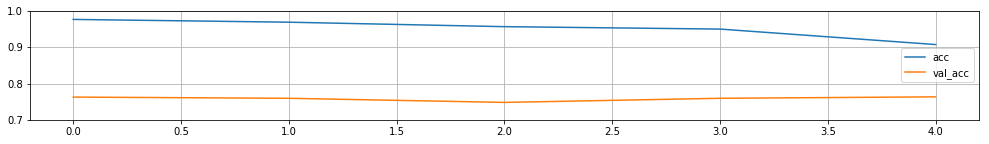

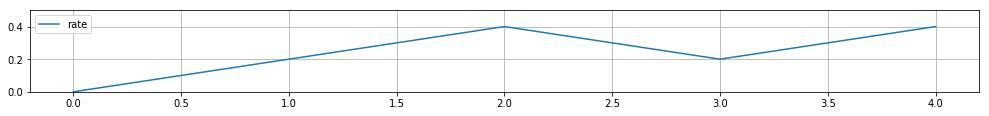

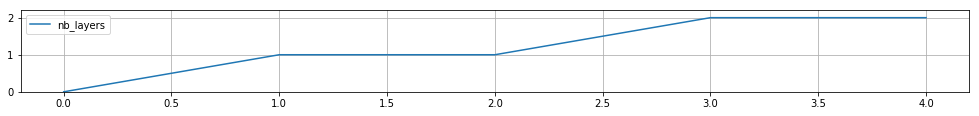

In [133]:

df = pd.DataFrame(data=dropout_means,columns=['acc','val_acc','rate','nb_layers'])
plt.rcParams["figure.figsize"] = [17,2]
plot=df[["acc","val_acc"]].plot()
plot.set_ylim([0.7,1])
plot.grid()

plt.rcParams["figure.figsize"] = [17,1.5]
plot=df[["rate"]].plot()
plot.set_ylim([0,0.5])
plot.grid()

plt.rcParams["figure.figsize"] = [17,1.5]
plot=df[["nb_layers"]].plot()
plot.set_ylim([0,2.2])
plot.grid()

# means=df[["acc","val_acc"]].mean()
# print("mean acc: {}, mean val_acc: {}".format(means["acc"],means["val_acc"]))


In [137]:
dropout_means

[[0.9916666746139526, 0.7480000058809916, 0.0, 0],
 [0.9473333358764648, 0.7366666793823242, 0.2, 1],
 [0.9349999825159708, 0.7506666580835978, 0.4, 1],
 [0.9576666752497355, 0.7593333522478739, 0.2, 2],
 [0.9026666482289633, 0.7380000154177347, 0.4, 2]]

### Observation<a class="anchor" id="opti_d_o"></a>
we have similar results, but got a higher test accuracy with low dropout on all layers and also less overfit (training and test accuracies are closer)